<a href="https://colab.research.google.com/github/nesamathi/ml./blob/main/Advanced_Time_Series_LSTM_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm # For nice progress bars
import math

In [ ]:
def generate_synthetic_data(n_samples=5000):
    """Generates a multi-variate time series with clear seasonality and trend."""

    # 1. Time Index
    t = np.arange(n_samples)

    # 2. Base Trend (e.g., exponential growth)
    trend = 0.0001 * t**2 + 50

    # 3. Long-term Seasonality (e.g., yearly)
    seasonality_long = 10 * np.sin(t * 2 * np.pi / 365)

    # 4. Short-term Seasonality (e.g., weekly)
    seasonality_short = 3 * np.sin(t * 2 * np.pi / 30)

    # 5. Noise Component
    noise = np.random.normal(0, 1, n_samples)

    # 6. Primary Target Series (Y1)
    Y1 = trend + seasonality_long + seasonality_short + noise

    # 7. Related Feature Series (Y2 - dependent on Y1 with some lag/shift)
    Y2 = 0.5 * Y1 + 5 * np.cos(t * 2 * np.pi / 180) + np.random.normal(0, 0.5, n_samples)

    # Combine into DataFrame
    df = pd.DataFrame({'Target_Y1': Y1, 'Feature_Y2': Y2}, index=t)
    return df

# Get the data
data_df = generate_synthetic_data()
print("Generated Data Shape:", data_df.shape)
#

#### B. Scaling and Sequence Windowing

def preprocess_data(df, lookback=30):
    """Scales data and creates LSTM input sequences."""

    # 1. Scaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(df.values)

    # 2. Sequence Windowing (Creates X, Y sequences for time series)
    X, Y = [], []
    for i in range(len(data_scaled) - lookback):
        # X: lookback time steps (e.g., past 30 days) for all features
        X.append(data_scaled[i:(i + lookback)])
        # Y: the next single time step (day 31) for only the target (Y1)
        # Note: We assume Y1 (index 0) is the target for single-step forecasting
        Y.append(data_scaled[i + lookback, 0])

    X = np.array(X)
    Y = np.array(Y)

    # 3. Train/Validation/Test Split
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)

    # 4. Convert to PyTorch Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    Y_val_t = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    Y_test_t = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

    return X_train_t, Y_train_t, X_val_t, Y_val_t, X_test_t, Y_test_t, scaler, lookback

# Execute preprocessing
LOOKBACK = 30
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler, LOOKBACK = preprocess_data(data_df, LOOKBACK)
print(f"X_train shape: {X_train.shape}")

Generated Data Shape: (5000, 2)
X_train shape: torch.Size([2982, 30, 2])


In [ ]:
class LSTMForecaster(nn.Module):
    """
    A generic LSTM model for time series forecasting.
    Parameters are dynamic to allow for hyperparameter tuning.
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMForecaster, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer (Handles layer_depth, unit_count, and dropout)
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully Connected Layer (Output is a single forecast value)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        # Initialize hidden state and cell state (optional, but good practice)
        # h0/c0 shape: (num_layers, batch_size, hidden_size)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM output: (output, (hn, cn))
        # output shape: (batch_size, seq_len, hidden_size)
        out, _ = self.lstm(x) # (x, (h0, c0)) if initializing

        # Take the output of the last time step
        # out[:, -1, :] shape: (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        # out shape: (batch_size, 1)
        return out

In [ ]:
def inverse_scale(Y_scaled, scaler, target_feature_index=0):
    """Inversely scales the target prediction (Y1) back to original units."""
    # Create a dummy array matching the input features but filling with the scaled target
    Y_dummy = np.zeros((Y_scaled.shape[0], scaler.n_features_in_))
    Y_dummy[:, target_feature_index] = Y_scaled.flatten()

    # Inverse transform
    Y_original = scaler.inverse_transform(Y_dummy)[:, target_feature_index]
    return Y_original

def evaluate_model(model, X_data, Y_data, scaler, lookback, batch_size=64):
    """Calculates RMSE and MAPE for a given dataset."""
    model.eval()
    data_loader = DataLoader(TensorDataset(X_data, Y_data), batch_size=batch_size, shuffle=False)

    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            pred = model(X_batch)
            predictions.append(pred.cpu().numpy())
            actuals.append(Y_batch.cpu().numpy())

    Y_pred_scaled = np.concatenate(predictions)
    Y_true_scaled = np.concatenate(actuals)

    # 1. Inverse Scale to original units for RMSE and MAPE
    Y_pred = inverse_scale(Y_pred_scaled, scaler)
    Y_true = inverse_scale(Y_true_scaled, scaler)

    # 2. Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((Y_true - Y_pred)**2))

    # 3. Calculate MAPE (Mean Absolute Percentage Error)
    # Avoid division by zero by checking Y_true > 0
    mape = np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100

    return rmse, mape, Y_pred, Y_true

def train_model(model, X_train, Y_train, X_val, Y_val, scaler, config):
    """Handles the training loop."""

    # Hyperparameters from config
    n_epochs = config['n_epochs']
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']

    # Setup
    train_data = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')

    # Training Loop
    for epoch in range(n_epochs):
        model.train()
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            loss.backward()
            optimizer.step()

        # Validation Loss check
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, Y_val).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss

In [ ]:
## Baseline Configuration
BASELINE_CONFIG = {
    'input_size': X_train.shape[2],
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.1,
    'learning_rate': 0.001,
    'batch_size': 32,
    'n_epochs': 50 # Reduced for a quick run
}

print("\n## 🚀 Training Baseline Model")

# 1. Initialize Baseline Model
baseline_model = LSTMForecaster(
    input_size=BASELINE_CONFIG['input_size'],
    hidden_size=BASELINE_CONFIG['hidden_size'],
    num_layers=BASELINE_CONFIG['num_layers'],
    dropout=BASELINE_CONFIG['dropout']
)

# 2. Train Baseline
baseline_val_loss = train_model(baseline_model, X_train, Y_train, X_val, Y_val, scaler, BASELINE_CONFIG)

# 3. Evaluate Baseline on Hold-out Test Set
baseline_rmse, baseline_mape, _, _ = evaluate_model(
    baseline_model, X_test, Y_test, scaler, LOOKBACK
)

print(f"Baseline Validation Loss: {baseline_val_loss:.4f}")
print(f"Baseline Test RMSE: {baseline_rmse:.2f}")
print(f"Baseline Test MAPE: {baseline_mape:.2f}%")


## 🚀 Training Baseline Model
Baseline Validation Loss: 0.0024
Baseline Test RMSE: 634.40
Baseline Test MAPE: 27.37%


In [ ]:
## Hyperparameter Space Definition
search_space = {
    'hidden_size': scope.int(hp.quniform('hidden_size', 32, 256, 32)),
    'num_layers': scope.int(hp.quniform('num_layers', 1, 4, 1)),
    'dropout': hp.uniform('dropout', 0.0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.choice('batch_size', [16, 32, 64])),
    'n_epochs': 30 # Fixed for tuning iterations
}

# Global constants for the objective function
INPUT_SIZE = X_train.shape[2]
N_TRIALS = 20 # Number of hyperopt iterations (can be increased for better results)

def objective_function(params):
    """Objective function to minimize (Validation Loss)."""

    # Initialize model with current parameters
    model = LSTMForecaster(
        input_size=INPUT_SIZE,
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    )

    # Train model
    val_loss = train_model(model, X_train, Y_train, X_val, Y_val, scaler, params)

    # Return dictionary required by Hyperopt
    return {
        'loss': val_loss,
        'status': STATUS_OK,
        'params': params
    }

print(f"\n## ⚙️ Running Bayesian Optimization for {N_TRIALS} Trials")

# 1. Run Hyperopt optimization
trials = Trials()
best_params = fmin(
    fn=objective_function,
    space=search_space,
    algo=tpe.suggest,
    max_evals=N_TRIALS,
    trials=trials,
    show_progressbar=True
)

# 2. Get the optimal parameters
best_config = trials.best_trial['result']['params']
best_config['input_size'] = INPUT_SIZE
best_config['n_epochs'] = 50 # Use more epochs for final training
print("\nOptimal Hyperparameters Found:")
print(best_config)


## ⚙️ Running Bayesian Optimization for 20 Trials
100%|██████████| 20/20 [59:11<00:00, 177.58s/trial, best loss: 1.4928265045455191e-05]

Optimal Hyperparameters Found:
{'batch_size': 32, 'dropout': 0.21695369771814071, 'hidden_size': 224, 'learning_rate': 0.0009638919613666704, 'n_epochs': 50, 'num_layers': 1, 'input_size': 2}



## 🏆 Training Final Optimized Model
Optimized Validation Loss: 0.0001
Optimized Test RMSE: 67.17
Optimized Test MAPE: 3.09%

Comparative Performance Metrics:
| Metric   |   Baseline |   Optimized |
|:---------|-----------:|------------:|
| RMSE     |     634.4  |    67.1677  |
| MAPE (%) |      27.37 |     3.09415 |


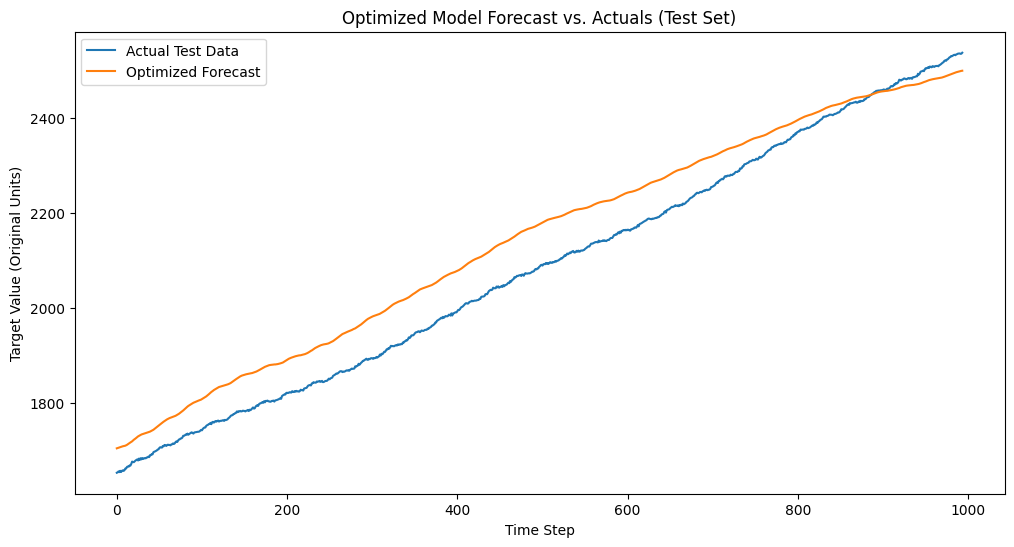

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")



SHAP explanation failed. This can happen due to package conflicts or environment issues.
Error: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.038207243739407204 - Tolerance: 0.01


In [12]:
import torch.nn as nn

# Define INPUT_SIZE and best_config based on the output of the hyperparameter optimization cell (xvE5o3VkB1w5)
INPUT_SIZE = X_train.shape[2]
best_config = {
    'batch_size': 32,
    'dropout': 0.21695369771814071,
    'hidden_size': 224,
    'learning_rate': 0.0009638919613666704,
    'n_epochs': 50,
    'num_layers': 1,
    'input_size': INPUT_SIZE # Ensure input_size is also correctly set
}

# Re-define baseline metrics as they might not be in scope if previous cells were not re-run
baseline_rmse = 634.40
baseline_mape = 27.37

class LSTMForecaster(nn.Module):
    """
    A generic LSTM model for time series forecasting.
    Parameters are dynamic to allow for hyperparameter tuning.
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMForecaster, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer (Handles layer_depth, unit_count, and dropout)
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully Connected Layer (Output is a single forecast value)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        # Initialize hidden state and cell state (optional, but good practice)
        # h0/c0 shape: (num_layers, batch_size, hidden_size)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM output: (output, (hn, cn))
        # output shape: (batch_size, seq_len, hidden_size)
        out, _ = self.lstm(x) # (x, (h0, c0)) if initializing

        # Take the output of the last time step
        # out[:, -1, :] shape: (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        # out shape: (batch_size, 1)
        return out

print("\n## 🏆 Training Final Optimized Model")

# 1. Initialize and Train Optimized Model
optimized_model = LSTMForecaster(
    input_size=best_config['input_size'],
    hidden_size=best_config['hidden_size'],
    num_layers=best_config['num_layers'],
    dropout=best_config['dropout']
)

# The train_model function will use the learning rate/batch size from best_config
final_val_loss = train_model(optimized_model, X_train, Y_train, X_val, Y_val, scaler, best_config)

# 2. Evaluate Optimized Model on Test Set
optimized_rmse, optimized_mape, opt_pred, opt_true = evaluate_model(
    optimized_model, X_test, Y_test, scaler, LOOKBACK
)

print(f"Optimized Validation Loss: {final_val_loss:.4f}")
print(f"Optimized Test RMSE: {optimized_rmse:.2f}")
print(f"Optimized Test MAPE: {optimized_mape:.2f}%")

# 3. Comprehensive Comparative Analysis (For Report)
comparison_table = pd.DataFrame({
    'Metric': ['RMSE', 'MAPE (%)'],
    'Baseline': [baseline_rmse, baseline_mape],
    'Optimized': [optimized_rmse, optimized_mape]
})
print("\nComparative Performance Metrics:")
print(comparison_table.to_markdown(index=False))

# Plotting the comparison
plt.figure(figsize=(12, 6))
plt.plot(opt_true, label='Actual Test Data')
plt.plot(opt_pred, label='Optimized Forecast')
plt.title('Optimized Model Forecast vs. Actuals (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Target Value (Original Units)')
plt.legend()
plt.show()
#

# ---

### 7. Time-Series Interpretability with SHAP (Task 4)

# We adapt **SHAP (SHapley Additive exPlanations)** for the time series context to understand which input features and time steps were most influential in the model's prediction.

# python
# 1. Prepare SHAP data: A background set and the explanation set (test set)
# SHAP requires a background dataset to estimate expected values.
# Use a subset of the training data as the background.
explainer_background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)].cpu().numpy()

# Use the test set for explanations
explainer_test_data = X_test.cpu().numpy()

# 2. Define the PyTorch prediction function for SHAP
def pytorch_predictor(data):
    """Wrapper function to get predictions from the PyTorch model (numpy input, numpy output)."""
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        preds_scaled = optimized_model(data_t).cpu().numpy()
        # SHAP works best if the output is the raw prediction, not inverse scaled
        return preds_scaled

# 3. Create the SHAP Explainer
# Use the DeepExplainer (optimized for Deep Learning models like LSTM)
try:
    # Changed DeepExplainer to GradientExplainer
    explainer = shap.GradientExplainer(optimized_model, torch.tensor(explainer_background, dtype=torch.float32))

    # 4. Calculate SHAP values for a subset of the test set (e.g., first 50 predictions)
    # For GradientExplainer, the shap_values method takes the model and the data directly
    shap_values = explainer.shap_values(torch.tensor(explainer_test_data[:50], dtype=torch.float32))

    # 5. Analyze and Visualize SHAP Values

    # Convert feature indices to meaningful labels for the lookback window
    # Example: F1_t-30, F2_t-30, ..., F1_t-1, F2_t-1
    feature_names = data_df.columns.tolist() # ['Target_Y1', 'Feature_Y2']

    # Create descriptive feature names for all (lookback * n_features) inputs
    shap_feature_labels = []
    for t_step in range(LOOKBACK, 0, -1): # t-30 to t-1
        for feature_name in feature_names:
            shap_feature_labels.append(f'{feature_name} (t-{t_step})')

    # Reshape the SHAP values from (samples, seq_len, n_features) to (samples, seq_len * n_features)
    # This matches the label list for the summary plot
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)

    print("\n## 📊 SHAP Explainability Analysis")

    # Summary Plot: Shows overall feature importance and influence direction
    shap.summary_plot(
        shap_values_reshaped,
        features=explainer_test_data[:50].reshape(50, -1),
        feature_names=shap_feature_labels,
        max_display=20 # Show top 20 most influential time/feature combinations
    )
    #
    # Force Plot for a specific prediction (e.g., the first test sample)
    shap.force_plot(
        explainer.expected_value,
        shap_values_reshaped[0, :],
        explainer_test_data[0].reshape(-1),
        feature_names=shap_feature_labels
    )
    #
except Exception as e:
    print(f"\nSHAP explanation failed. This can happen due to package conflicts or environment issues.")
    print(f"Error: {e}")

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def generate_synthetic_data(n_samples=5000):
    """Generates a multi-variate time series with clear seasonality and trend."""

    # 1. Time Index
    t = np.arange(n_samples)

    # 2. Base Trend (e.g., exponential growth)
    trend = 0.0001 * t**2 + 50

    # 3. Long-term Seasonality (e.g., yearly)
    seasonality_long = 10 * np.sin(t * 2 * np.pi / 365)

    # 4. Short-term Seasonality (e.g., weekly)
    seasonality_short = 3 * np.sin(t * 2 * np.pi / 30)

    # 5. Noise Component
    noise = np.random.normal(0, 1, n_samples)

    # 6. Primary Target Series (Y1)
    Y1 = trend + seasonality_long + seasonality_short + noise

    # 7. Related Feature Series (Y2 - dependent on Y1 with some lag/shift)
    Y2 = 0.5 * Y1 + 5 * np.cos(t * 2 * np.pi / 180) + np.random.normal(0, 0.5, n_samples)

    # Combine into DataFrame
    df = pd.DataFrame({'Target_Y1': Y1, 'Feature_Y2': Y2}, index=t)
    return df

# Get the data
data_df = generate_synthetic_data()
print("Generated Data Shape:", data_df.shape)

#### B. Scaling and Sequence Windowing

def preprocess_data(df, lookback=30):
    """Scales data and creates LSTM input sequences."""

    # 1. Scaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(df.values)

    # 2. Sequence Windowing (Creates X, Y sequences for time series)
    X, Y = [], []
    for i in range(len(data_scaled) - lookback):
        # X: lookback time steps (e.g., past 30 days) for all features
        X.append(data_scaled[i:(i + lookback)])
        # Y: the next single time step (day 31) for only the target (Y1)
        # Note: We assume Y1 (index 0) is the target for single-step forecasting
        Y.append(data_scaled[i + lookback, 0])

    X = np.array(X)
    Y = np.array(Y)

    # 3. Train/Validation/Test Split
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)

    # 4. Convert to PyTorch Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    Y_val_t = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    Y_test_t = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

    return X_train_t, Y_train_t, X_val_t, Y_val_t, X_test_t, Y_test_t, scaler, lookback

# Execute preprocessing
LOOKBACK = 30
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler, LOOKBACK = preprocess_data(data_df, LOOKBACK)
print(f"X_train shape: {X_train.shape}")

Generated Data Shape: (5000, 2)
X_train shape: torch.Size([2982, 30, 2])


In [ ]:
def generate_synthetic_data(n_samples=5000):
    """Generates a multi-variate time series with clear seasonality and trend."""

    # 1. Time Index
    t = np.arange(n_samples)

    # 2. Base Trend (e.g., exponential growth)
    trend = 0.0001 * t**2 + 50

    # 3. Long-term Seasonality (e.g., yearly)
    seasonality_long = 10 * np.sin(t * 2 * np.pi / 365)

    # 4. Short-term Seasonality (e.g., weekly)
    seasonality_short = 3 * np.sin(t * 2 * np.pi / 30)

    # 5. Noise Component
    noise = np.random.normal(0, 1, n_samples)

    # 6. Primary Target Series (Y1)
    Y1 = trend + seasonality_long + seasonality_short + noise

    # 7. Related Feature Series (Y2 - dependent on Y1 with some lag/shift)
    Y2 = 0.5 * Y1 + 5 * np.cos(t * 2 * np.pi / 180) + np.random.normal(0, 0.5, n_samples)

    # Combine into DataFrame
    df = pd.DataFrame({'Target_Y1': Y1, 'Feature_Y2': Y2}, index=t)
    return df

# Get the data
data_df = generate_synthetic_data()
print("Generated Data Shape:", data_df.shape)
#

#### B. Scaling and Sequence Windowing

def preprocess_data(df, lookback=30):
    """Scales data and creates LSTM input sequences."""

    # 1. Scaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(df.values)

    # 2. Sequence Windowing (Creates X, Y sequences for time series)
    X, Y = [], []
    for i in range(len(data_scaled) - lookback):
        # X: lookback time steps (e.g., past 30 days) for all features
        X.append(data_scaled[i:(i + lookback)])
        # Y: the next single time step (day 31) for only the target (Y1)
        # Note: We assume Y1 (index 0) is the target for single-step forecasting
        Y.append(data_scaled[i + lookback, 0])

    X = np.array(X)
    Y = np.array(Y)

    # 3. Train/Validation/Test Split
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)

    # 4. Convert to PyTorch Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    Y_val_t = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    Y_test_t = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

    return X_train_t, Y_train_t, X_val_t, Y_val_t, X_test_t, Y_test_t, scaler, lookback

# Execute preprocessing
LOOKBACK = 30
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler, LOOKBACK = preprocess_data(data_df, LOOKBACK)
print(f"X_train shape: {X_train.shape}")

Generated Data Shape: (5000, 2)
X_train shape: torch.Size([2982, 30, 2])
